In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

### загружаем обработанную таблицу и разбиваем на обучающий и валидационный набор

In [69]:
df = pd.read_csv('processd_df.csv', sep = ';') #загрузка таблицы
y = df['CO(GT)'] #берём таргет
x = df.loc[:, ['Month', 'Weekday', 'Hour', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']] #оставляем столбцы без таргета
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) #разбиваем на обучающую и валидационные выборки

### Нормализуем данные при помощи класса StandardScaler пакета sklearn. 

In [70]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #находим параметры нормализации и на месте нормализуем обучающий набор
X_test = scaler.transform(X_test) # также валидационынй набор

In [202]:
with open('models\scaler.pkl', 'wb') as file: #сохраняем StandartScaler для использования его параметрах на данных для предсказания
    pickle.dump(scaler, file)

### Далее поочерёдно обучаем Линейную модель, Лассо, Случайный лес, Support Vector Regressor (SVR), К-ближайших соседей и полносвязанную нейронную сеть

In [182]:
lin_model = LinearRegression() #загружаем модель
lin_model.fit(X_train, y_train) #обучаем на данных
y_pred = lin_model.predict(X_test) #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Метрика R2: 0.9184234442438407
MAE: 0.24967928601306663


In [179]:
with open('models\linear_model.pkl', 'wb') as file: #сохраняем линейную модель
    pickle.dump(lin_model, file)

### Обучаем Lasso и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [10]:
lasso_model = Lasso() #загружаем модель
parameters = {'alpha': [0.1, 0.5, 1, 3, 5]} #гиперпараметы (всего 5 вариантов модели с  разными гиперпараметрами будет построено)
lasso = GridSearchCV(lasso_model, parameters)
lasso.fit(X_train, y_train) #обучаем на данных
y_pred = lasso.predict(X_test) #делаем предсказания
print('Лучшие гиперпараметры', lasso.best_params_)  #смотрим лучший вариант гиперпараметров
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'alpha': 0.1}
Метрика R2: 0.9096827831592366
MAE: 0.26393723019037146


In [183]:
with open('models\lasso_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(lasso, file)

### Обучаем Support Vector Regressor и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [184]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5, 10, 12]}  #гиперпараметы (всего 8 вариантов модели с  разными гиперпараметрами будет построено)
svr_model = SVR() #загружаем модель
svr = GridSearchCV(svr_model, parameters)
svr.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', svr.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = svr.predict(X_test)#делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'C': 12, 'kernel': 'rbf'}
Метрика R2: 0.9582851577546982
MAE: 0.16804714849495195


In [185]:
with open('models\svr_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(svr, file)

### Обучаем Случайный лес и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 3

In [186]:
forest_model = RandomForestRegressor(warm_start = True) #загружаем модель
parameters = {'n_estimators':(100, 150, 200), 
                'criterion':['squared_error', 'absolute_error'],
                'max_depth': [15, 20],
                'max_features': ['sqrt', 'log2']}  #гиперпараметы (всего 24 вариантов модели с  разными гиперпараметрами будет построено)


forest = GridSearchCV(forest_model, parameters, cv = 3)
forest.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', forest.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = forest.predict(X_test) #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
Метрика R2: 0.937878178448896
MAE: 0.20816606826314796


In [187]:
with open(r'models\forest_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(forest, file)

### Обучаем К ближайших соседей и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [188]:
#K-ближайших соседей
neigh_model = KNeighborsRegressor()
parameters = {'n_neighbors': (3, 5, 7, 9, 11), 
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree']} #гиперпараметы (всего 30 вариантов модели с  разными гиперпараметрами будет построено)


neigh = GridSearchCV(neigh_model, parameters)
neigh.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', neigh.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = neigh.predict(X_test)  #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
Метрика R2: 0.9449495321123889
MAE: 0.2190635558916494


In [189]:
with open(r'models\knn_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(neigh, file)

In [6]:
boosting_model = GradientBoostingRegressor()
parameters = {'loss': ['squared_error', 'huber'], 
                'learning_rate': [0.1, 0.05],
                'n_estimators': [100, 150, 200]} #гиперпараметы (всего 12 вариантов модели с  разными гиперпараметрами будет построено)

boosting = GridSearchCV(boosting_model, parameters)
boosting.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', boosting.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = boosting.predict(X_test)  #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'learning_rate': 0.1, 'loss': 'squared_error', 'n_estimators': 200}
Метрика R2: 0.936831457643704
MAE: 0.2168103120171699


In [8]:
with open(r'models\boosting_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(boosting, file)

### Далее создаём полносвязанную нейронную сеть, состоящую из 4 линейных слоёв, функции активации ReLu, нормализации и Dropout с вероятность 0.2. Для этого используем пакет pytroch

In [36]:
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

In [53]:
#создаём класс для загрузки данных
class air_dataset(Dataset): #наследуем от родительского класса Dataset
    def __init__(self, x_train, y_train):
        self.x = x_train
        self.y = y_train
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, ind): 
        features = torch.from_numpy(self.x[ind]).to(torch.float32)  #переводим столбец таблицы в формата тензора с числами float 32
        label = torch.tensor(self.y.iloc[ind]).to(torch.float32) #переводим столбец таблицы в формата тензора с числами float 32
        return features, label  #возвращаем тензор с признаками и тензор с таргетами
    

In [54]:
train_dataset = air_dataset(X_train, y_train) #инициализируем класс загрузки данных для обучающего набора
test_dataset = air_dataset(X_test, y_test) #инициализируем класс загрузки данных для валидационного набора

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True) #создаём dataloader для обучающего набора
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False) #создаём dataloader для валидационного набора

### Создаём класс полносвязанной нейронной сети

In [56]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        #простая последовательность слоёв
        self.layers = nn.Sequential(nn.Linear(in_features=14, out_features = 14), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(14), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=14, out_features = 8), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(8), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=8, out_features = 4), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(4), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=4, out_features = 1), #линейный слой
                                    nn.ReLU() #нелинейная функция активации
        )
    
    def forward(self, input): #функция прямого прохода нейроннйо сети
        return self.layers(input)

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #если видеокарта доступна, то обучаем на ней
model = DenseNet().to(device) #инициализируем модель и переносим на доступное устрйоство
epochs = 8 #количество эпох
lr = 0.01 #шаг обучения
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # оптимизаторв Adam
loss_fn = nn.MSELoss() #функция потерь MSE
print(f'Обучение будет проходить на {device}')

Обучение будет проходить на cuda


In [60]:
for epoch in range(epochs): # начинаем обучение в цикле
    
    #инициализруем метрики, которые будем считать по эпохам
    train_loss = 0
    r2_train = 0
    r2_test = 0
    test_loss = 0

    model.train() #переводим модель в режим обучения
    for batch, y in train_loader: #берём батч и таргет
        batch, y = batch.to(device), y.to(device)  #переносим на доступное устрйоство
        y_pred = model(batch).squeeze() #делаем предсказание
        loss = loss_fn(y, y_pred) #счиатем потери
        train_loss += loss.item()/len(train_loader) #сохраняем потери на текущей итерации
        r2_train += r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())/len(train_loader) #счиатем метрику на текущей итерации
        loss.backward() #обратное распространение ошибки
        optimizer.step() #обновляем веса модели
        optimizer.zero_grad() #обнулдяем градиент

    model.eval() #переводим модель в режим предсказания
    with torch.no_grad(): #отключаем подсчёт градиента 
        for batch, y in test_loader: #берём батч и таргет
            batch, y = batch.to(device), y.to(device) #переносим на доступное устрйоство
            y_pred = model(batch).squeeze() #делаем предсказание
            loss = loss_fn(y, y_pred) #счиатем потери
            test_loss += loss.item()/len(test_loader) #сохраняем потери на текущей итерации
            r2_test += r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())/len(test_loader) #счиатем метрику на текущей итерации
    
    print(f'Эпоха обучения {epoch + 1}')
    print(f'Потеря на обучении: {train_loss}', f'R2 на обучении: {r2_train}')
    print(f'Потеря на валидации: {test_loss}', f'R2 на валидации: {r2_test}')

Эпоха обучения 1
Потеря на обучении: 1.5348379605886888 R2 на обучении: 0.22310859032989763
Потеря на валидации: 0.30933473507563275 R2 на валидации: 0.8260847047501676
Эпоха обучения 2
Потеря на обучении: 0.748789160531394 R2 на обучении: 0.6272092056930112
Потеря на валидации: 0.265228216846784 R2 на валидации: 0.850934298325829
Эпоха обучения 3
Потеря на обучении: 0.6411294900641149 R2 на обучении: 0.6809028467028738
Потеря на валидации: 0.25141756484905875 R2 на валидации: 0.8591473523166282
Эпоха обучения 4
Потеря на обучении: 0.5841344594955442 R2 на обучении: 0.7163099247906555
Потеря на валидации: 0.19792191435893378 R2 на валидации: 0.8891871861045336
Эпоха обучения 5
Потеря на обучении: 0.5430430776002455 R2 на обучении: 0.7274433216659179
Потеря на валидации: 0.18936079492171604 R2 на валидации: 0.8936029184015152
Эпоха обучения 6
Потеря на обучении: 0.5153614738766027 R2 на обучении: 0.747897219648755
Потеря на валидации: 0.271955447892348 R2 на валидации: 0.847957686652106

In [61]:
torch.save(model, r'models\nn.pt') #сохраняем обученную модель

### Итоговые потери и метрика R2 по всем построенным моделям с лучшей комбинацией гиперпараметров

In [62]:
metrics_df = pd.DataFrame(data = [[0.918, 0.249, 'Линейная модель'],
                                 [0.909, 0.263, 'Лассо'],       
                                 [0.958, 0.168, 'SVR'],
                                 [0.937, 0.208, 'Случайный лес'],
                                 [0.944, 0.219, 'KNN'],
                                 [0.936, 0.216, 'Градиентный \nбустинг'],
                                 [0.893, 0.188, 'Полносвязанная \n нейронная сеть']], columns = ['R2', 'MAE', 'Модель'])
metrics_df                                 

,R2,MAE,Модель
0,0.918,0.249,Линейная модель
1,0.909,0.263,Лассо
2,0.958,0.168,SVR
3,0.937,0.208,Случайный лес
4,0.944,0.219,KNN
5,0.936,0.216,Градиентный \nбустинг
6,0.893,0.188,Полносвязанная \n нейронная сеть


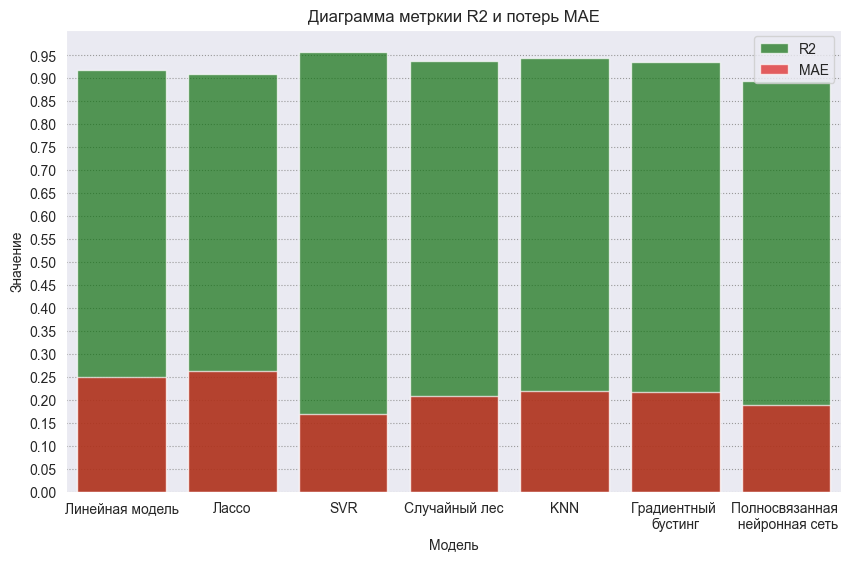

In [63]:
plt.figure(figsize=(10, 6))
 
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax = sns.barplot(x='Модель', y='R2', data=metrics_df, color='green', alpha=0.7, label='R2')
sns.barplot(x='Модель', y='MAE', data=metrics_df, color='red', alpha=0.7, label='MAE', ax = ax)
plt.yticks(np.arange(0, 1, 0.05))  
plt.xlabel('Модель')
plt.ylabel('Значение')
plt.title('Диаграмма метркии R2 и потерь MAE')
plt.legend() 
plt.show() 
fig = ax.get_figure()
fig.savefig('Диаграмма метркии R2 и потерь MAE')
